Dataset: http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes

In [11]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv('pima-indians-diabetes.data', header=None,
                 names=['preg', 'gluc', 'blood_p', 'skin', 'insu', 'bmi', 'pedi', 'age', 'class'])
df.head()

,preg,gluc,blood_p,skin,insu,bmi,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.describe()

,preg,gluc,blood_p,skin,insu,bmi,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
bins = range(10, 60, 6)
df['bmi_bin'] = pd.cut(df['bmi'], bins, labels=bins[:-1])
df.head()

,preg,gluc,blood_p,skin,insu,bmi,pedi,age,class,bmi_bin
0,6,148,72,35,0,33.6,0.627,50,1,28
1,1,85,66,29,0,26.6,0.351,31,0,22
2,8,183,64,0,0,23.3,0.672,32,1,22
3,1,89,66,23,94,28.1,0.167,21,0,28
4,0,137,40,35,168,43.1,2.288,33,1,40


In [5]:
grouped = df[['bmi_bin', 'class']].groupby(['bmi_bin'], as_index=False).mean()
grouped['class'] = grouped['class'].fillna(0.0)
df = df.drop('bmi_bin', axis=1)
grouped

,bmi_bin,class
0,10,0.000000
1,16,0.000000
2,22,0.153005
3,28,0.400810
4,34,0.433673
5,40,0.535211
6,46,0.588235
7,52,0.666667


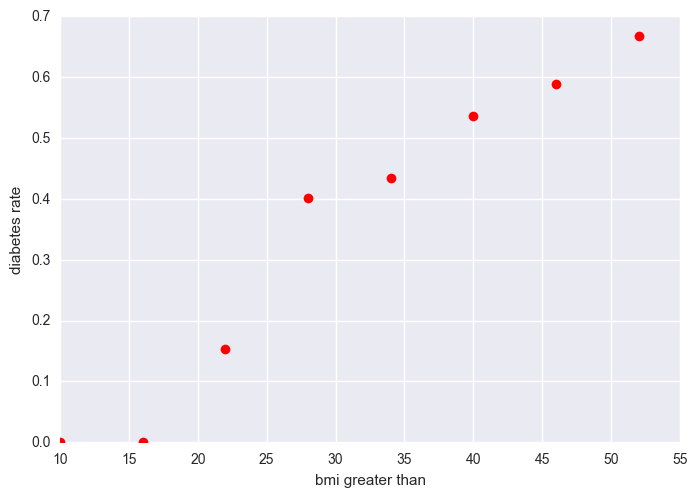

In [6]:
plt.plot(bins[:-1], grouped['class'], 'ro')
plt.xlabel('bmi greater than')
plt.ylabel('diabetes rate')
plt.show()

In [7]:
X, y = df.drop('class', axis=1), df['class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

~~~~
Best parameters set found on development set:

{'C': 1000, 'kernel': 'linear'}

Grid scores on development set:

0.687 (+/-0.047) for {'gamma': 0.001, 'C': 1, 'kernel': 'rbf'}
0.686 (+/-0.067) for {'gamma': 0.0001, 'C': 1, 'kernel': 'rbf'}
0.676 (+/-0.068) for {'gamma': 0.001, 'C': 10, 'kernel': 'rbf'}
0.692 (+/-0.062) for {'gamma': 0.0001, 'C': 10, 'kernel': 'rbf'}
0.634 (+/-0.070) for {'gamma': 0.001, 'C': 100, 'kernel': 'rbf'}
0.702 (+/-0.083) for {'gamma': 0.0001, 'C': 100, 'kernel': 'rbf'}
0.627 (+/-0.061) for {'gamma': 0.001, 'C': 1000, 'kernel': 'rbf'}
0.700 (+/-0.045) for {'gamma': 0.0001, 'C': 1000, 'kernel': 'rbf'}
0.717 (+/-0.067) for {'C': 1, 'kernel': 'linear'}
0.709 (+/-0.064) for {'C': 10, 'kernel': 'linear'}
0.713 (+/-0.060) for {'C': 100, 'kernel': 'linear'}
0.727 (+/-0.092) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.81      0.73      0.77        99
          1       0.58      0.69      0.63        55

avg / total       0.73      0.71      0.72       154
~~~~

Comparing different estimators in one grid search from http://www.codiply.com/blog/hyperparameter-grid-search-across-multiple-models-in-scikit-learn/

I had to make some adaptions to port it to Python 3 (should probably communicate them back to the author)

In [8]:
class EstimatorSelectionHelper:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=1, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, 
                              verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series(dict(params.items() | d.items()))

        rows = [row(k, gsc.cv_validation_scores, gsc.parameters) 
                     for k in self.keys
                     for gsc in self.grid_searches[k].grid_scores_]
        df = pd.concat(rows, axis=1).T.sort([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [19]:
models1 = { 
    #'GaussianNB' : GaussianNB()#,
    #'KNeighborsClassifier' : KNeighborsClassifier(),
    #'ExtraTreesClassifier': ExtraTreesClassifier(),
    #'RandomForestClassifier': RandomForestClassifier(),
    #'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    #'SVC': SVC()
}

params1 = { 
    #'GaussianNB': {},
    #'KNeighborsClassifier': {'n_neighbors': [1, 2, 3, 4, 5, 10, 15] },
    #'ExtraTreesClassifier': { 'n_estimators': [16, 32, 64, 128] },
    #'RandomForestClassifier': { 'n_estimators': [16, 32, 64, 128] },
    #'AdaBoostClassifier':  { 'n_estimators': [16, 32, 64, 128] },
    'GradientBoostingClassifier': { 'n_estimators': list(range(40, 60, 1)), 'learning_rate': [1.0] },
    #'SVC': {'kernel': ['linear'], 'C': [1, 10, 100, 1000, 10000], 'gamma': [0.001]}
}

helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train, y_train, scoring='f1', n_jobs=-1)

helper1.score_summary(sort_by='min_score')

Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:    6.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.4s finished
C:\Users\Christian\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\Christian\Anaconda3\lib\site-packages\ipykernel\__main__.py:35: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,estimator,min_score,mean_score,max_score,std_score,learning_rate,n_estimators
6,GradientBoostingClassifier,0.671533,0.672914,0.675676,0.00195295,1,46
13,GradientBoostingClassifier,0.671429,0.677606,0.685714,0.00598974,1,53
5,GradientBoostingClassifier,0.666667,0.674501,0.681159,0.0059747,1,45
15,GradientBoostingClassifier,0.666667,0.669864,0.676259,0.00452187,1,55
4,GradientBoostingClassifier,0.661871,0.668265,0.676259,0.00598187,1,44
3,GradientBoostingClassifier,0.657143,0.66669,0.676259,0.00780415,1,43
11,GradientBoostingClassifier,0.657143,0.663419,0.671141,0.00580553,1,51
10,GradientBoostingClassifier,0.653061,0.662154,0.676259,0.0101117,1,50
1,GradientBoostingClassifier,0.653061,0.655782,0.657143,0.0019241,1,41
18,GradientBoostingClassifier,0.652482,0.663603,0.676259,0.00976726,1,58
